<a href="https://colab.research.google.com/github/angelasimon58/TIA_UNIR/blob/main/TFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de detección temprana de retinopatía diabética

## Importación de librerías

In [1]:
# Librerías para el preprocesamiento
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split

# Librerías para el diseño de la red neuronal
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


## Carga de datos

In [2]:
# Montaje de Google Drive en Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Directorio de las imágenes
data_dir = '/content/drive/MyDrive/Retina/gaussian_filtered_images'
labels_path = '/content/drive/MyDrive/Retina/train.csv'

labels_df = pd.read_csv(labels_path)

# Etiquetado de las clases
label_map = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR'
}


In [4]:
# Creación de las rutas de las imágenes
image_paths = []
labels = []
for index, row in labels_df.iterrows():
    image_filename = row['id_code']
    label = row['diagnosis']
    image_path = os.path.join(data_dir, f"{label_map[label]}/{image_filename}.png")
    image_paths.append(image_path)
    labels.append(label)

### División de los datos en entrenamiento y validación

In [5]:
X_train_paths, X_val_paths, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

## Preprocesamiento de los datos

In [6]:
# Ajuste del tamaño de la imagen y número de lotes
image_size = (224, 224)
batch_size = 32

In [7]:
# Función para preprocesar una única imagen
def preprocess_image(image_path, target_size):
    """Load and preprocess a single image."""
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize to [0, 1]
    return image

In [8]:
# Generador de datos para el entrenamiento
train_datagen = ImageDataGenerator(preprocessing_function=lambda x: x / 255.0)

def train_generator(X_paths, y, batch_size, image_size):
    while True:
        for start in range(0, len(X_paths), batch_size):
            end = min(start + batch_size, len(X_paths))
            X_batch_paths = X_paths[start:end]
            y_batch = y[start:end]
            X_batch = np.array([preprocess_image(img_path, image_size) for img_path in X_batch_paths])
            yield X_batch, np.array(y_batch)


In [9]:
# Generador de datos para la validación
val_datagen = ImageDataGenerator(preprocessing_function=lambda x: x / 255.0)

def val_generator(X_paths, y, batch_size, image_size):
    while True:
        for start in range(0, len(X_paths), batch_size):
            end = min(start + batch_size, len(X_paths))
            X_batch_paths = X_paths[start:end]
            y_batch = y[start:end]
            X_batch = np.array([preprocess_image(img_path, image_size) for img_path in X_batch_paths])
            yield X_batch, np.array(y_batch)


## Diseño de la red neuronal

### Modelo base

In [10]:
# Cargar la arquitectura de VGG16 sin la capa de clasificación superior
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Congelar las capas convolucionales
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas de clasificación
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

# Crear el modelo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Propuesta 3

In [ ]:
# Cargar la arquitectura de VGG16 sin la capa de clasificación superior
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Fragmento de código añadido en la Propuesta de mejora 3, que descongela las últimas 4 capas convolucionales de la red neuronal
for layer in base_model.layers[-4:]:
      layer.trainable = True

# Añadir capas de clasificación
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

# Crear el modelo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Propuesta 4

In [12]:
from tensorflow.keras.regularizers import l2
# Cargar la arquitectura de VGG16 sin la capa de clasificación superior
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Fragmento de código añadido en la Propuesta de mejora 3, que descongela las últimas 4 capas convolucionales de la red neuronal
for layer in base_model.layers[-4:]:
      layer.trainable = True

# Añadir capas de clasificación
x = Flatten()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

# Crear el modelo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 82,688,465 (315.43 MB)

 Trainable params: 27,562,821 (105.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 55,125,644 (210.29 MB)

## Entrenamiento del modelo

In [13]:
history = model.fit(
    train_generator(X_train_paths, y_train, batch_size, image_size),
    steps_per_epoch=len(X_train_paths) // batch_size,
    validation_data=val_generator(X_val_paths, y_val, batch_size, image_size),
    validation_steps=len(X_val_paths) // batch_size,
    epochs=10
)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2968s 32s/step - accuracy: 0.5429 - loss: 8.8591 - val_accuracy: 0.7216 - val_loss: 3.6527
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 89s 674ms/step - accuracy: 0.6777 - loss: 3.1520 - val_accuracy: 0.7261 - val_loss: 2.1074
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 49s 539ms/step - accuracy: 0.7053 - loss: 1.9694 - val_accuracy: 0.7347 - val_loss: 1.6404
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 527ms/step - accuracy: 0.7304 - loss: 1.5483 - val_accuracy: 0.7646 - val_loss: 1.3388
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 49s 536ms/step - accuracy: 0.7641 - loss: 1.2734 - val_accuracy: 0.7646 - val_loss: 1.1629
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 530ms/step - accuracy: 0.7673 - loss: 1.0930 - val_accuracy: 0.7561 - val_loss: 1.0880
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 528ms/step - accuracy: 0.7742 - loss: 0.9825 - val_accuracy: 0.7660 - val_loss: 0.9707
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 529ms/step - accuracy: 0.7867 - loss: 0.9072 - val_accu

## Evaluación del modelo

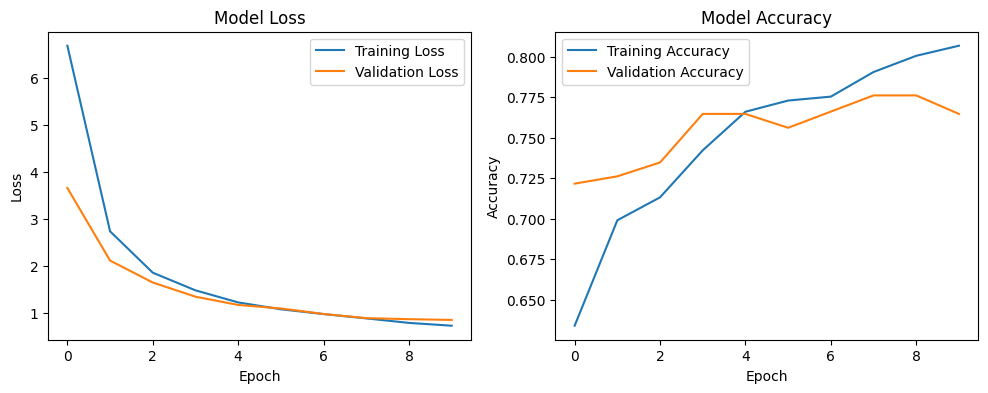

In [14]:
import matplotlib.pyplot as plt

# Pérdida (Loss)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [15]:
# Definir el generador de prueba (similar a train_generator)
test_generator = train_generator(X_val_paths, y_val, batch_size, image_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(X_val_paths) // batch_size)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.7901 - loss: 0.7993
Test Loss: 0.8308227062225342
Test Accuracy: 0.7713068127632141


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step


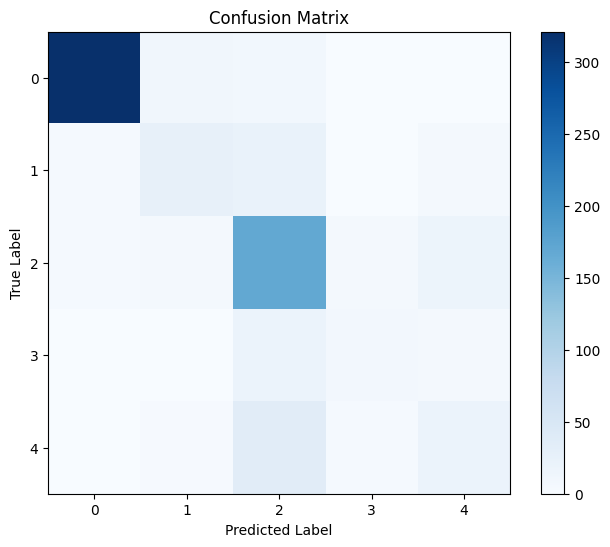

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       341
           1       0.55      0.43      0.48        61
           2       0.66      0.83      0.73       204
           3       0.40      0.23      0.29        35
           4       0.38      0.30      0.34        63

    accuracy                           0.77       704
   macro avg       0.59      0.55      0.56       704
weighted avg       0.76      0.77      0.76       704



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Obtener las predicciones del modelo
y_pred_probs = model.predict(test_generator, steps=len(X_val_paths) // batch_size)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_val[:len(y_pred)], y_pred)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Imprimir el reporte de clasificación
print(classification_report(y_val[:len(y_pred)], y_pred))
